In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
DATASET_PATH = '/content/drive/MyDrive/weather_dataset/dataset'

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.preprocessing import label_binarize
import time
import os
import pandas as pd
from tqdm import tqdm
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

In [4]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [5]:
OUTPUT_PATH = '/content/drive/MyDrive/processed_data'
preprocessing_info = np.load(os.path.join(OUTPUT_PATH, 'preprocessing_info.npy'),
                             allow_pickle=True).item()

IMG_SIZE = preprocessing_info['img_size']
NUM_CLASSES = preprocessing_info['num_classes']
CLASS_NAMES = preprocessing_info['class_names']
CLASS_WEIGHTS = preprocessing_info['class_weights']

print("INCEPTION V1 (GoogLeNet) TRANSFER LEARNING - WEATHER CLASSIFICATION")
print("="*70)
print(f"Image Size: {IMG_SIZE}")
print(f"Number of Classes: {NUM_CLASSES}")
print(f"Classes: {CLASS_NAMES}")
print(f"Using: torchvision.models.googlenet with DEFAULT weights")


INCEPTION V1 (GoogLeNet) TRANSFER LEARNING - WEATHER CLASSIFICATION
Image Size: (224, 224)
Number of Classes: 5
Classes: ['cloudy', 'foggy', 'rainy', 'shine', 'sunrise']
Using: torchvision.models.googlenet with DEFAULT weights


In [8]:
def build_googlenet_transfer_learning(num_classes=NUM_CLASSES):
    """
    Build GoogLeNet model with transfer learning
    USING EXACT CODE SPECIFIED: models.googlenet with DEFAULT weights

    Transfer Learning Strategy:
    1. Load pre-trained GoogLeNet from torchvision
    2. Freeze all base layers (transfer learning)
    3. Replace final fc layer for our task
    4. Fine-tune if needed

    GoogLeNet Architecture Highlights:
    - 9 inception modules with parallel branches
    - Multi-scale feature extraction (1x1, 3x3, 5x5)
    - 1x1 convolutions for dimensionality reduction
    - Global average pooling
    - Original: 22 layers, ~6.8M parameters
    """

    print("\n" + "="*70)
    print("LOADING GOOGLENET WITH PRE-TRAINED WEIGHTS")
    print("="*70)

    # ============== EXACT CODE FROM YOUR SPECIFICATION ==============
    print("Loading model with EXACT code you specified...")
    model = models.googlenet(
        weights=models.GoogLeNet_Weights.DEFAULT,
        aux_logits=True  # We don't need auxiliary classifiers
    )
    # ================================================================

    print("✓ GoogLeNet loaded with DEFAULT pre-trained weights")

    # Freeze all parameters (TRANSFER LEARNING)
    for param in model.parameters():
        param.requires_grad = False

    print("✓ Frozen all base model parameters for transfer learning")

    # Replace the final fully connected layer for our task
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    print(f"✓ Replaced fc layer: {model.fc.in_features} → {num_classes} classes")

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"\n Model Statistics:")
    print(f"  Total parameters: {total_params:,}")
    print(f"  Trainable parameters: {trainable_params:,}")
    print(f"  Frozen parameters: {total_params - trainable_params:,}")
    print(f"  % Trainable: {(trainable_params/total_params*100):.2f}%")

    # Move model to device
    model = model.to(device)

    return model

# Build the model
print("\nBuilding GoogLeNet with transfer learning...")
googlenet_model = build_googlenet_transfer_learning()


Building GoogLeNet with transfer learning...

LOADING GOOGLENET WITH PRE-TRAINED WEIGHTS
Loading model with EXACT code you specified...
✓ GoogLeNet loaded with DEFAULT pre-trained weights
✓ Frozen all base model parameters for transfer learning
✓ Replaced fc layer: 1024 → 5 classes

 Model Statistics:
  Total parameters: 11,985,013
  Trainable parameters: 5,125
  Frozen parameters: 11,979,888
  % Trainable: 0.04%


In [9]:
# Load split data
X_train = np.load(os.path.join(OUTPUT_PATH, 'X_train.npy'), allow_pickle=True)
X_val = np.load(os.path.join(OUTPUT_PATH, 'X_val.npy'), allow_pickle=True)
X_test = np.load(os.path.join(OUTPUT_PATH, 'X_test.npy'), allow_pickle=True)
y_train = np.load(os.path.join(OUTPUT_PATH, 'y_train.npy'), allow_pickle=True)
y_val = np.load(os.path.join(OUTPUT_PATH, 'y_val.npy'), allow_pickle=True)
y_test = np.load(os.path.join(OUTPUT_PATH, 'y_test.npy'), allow_pickle=True)

# Define transforms (matching ImageNet preprocessing)
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Data augmentation for training
train_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Custom Dataset
class WeatherDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Create datasets
train_dataset = WeatherDataset(X_train, y_train, transform=train_transform)
val_dataset = WeatherDataset(X_val, y_val, transform=transform)
test_dataset = WeatherDataset(X_test, y_test, transform=transform)

# Create data loaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"✓ Created PyTorch DataLoaders:")
print(f"  Training samples: {len(train_dataset)}")
print(f"  Validation samples: {len(val_dataset)}")
print(f"  Test samples: {len(test_dataset)}")
print(f"  Batch size: {BATCH_SIZE}")

✓ Created PyTorch DataLoaders:
  Training samples: 1050
  Validation samples: 300
  Test samples: 150
  Batch size: 32


In [14]:
# Create model save path
model_save_path = '/content/drive/MyDrive/models/inception_v1'
os.makedirs(model_save_path, exist_ok=True)

def train_model_phase1(model, train_loader, val_loader, num_epochs=20, learning_rate=0.001):
    """
    Phase 1: Train only the fc layer (transfer learning)
    """
    print(" Phase 1: Training only fc layer (base model frozen)...")

    # Define loss function with class weights
    class_weights_tensor = torch.FloatTensor(list(CLASS_WEIGHTS.values())).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

    # Only optimize the fc layer parameters (transfer learning)
    optimizer = torch.optim.Adam(model.fc.parameters(), lr=learning_rate)

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )

    # Training history
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'learning_rate': []
    }

    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(num_epochs):
        print(f"\n📊 Epoch {epoch+1}/{num_epochs}")

        # ========== TRAINING PHASE ==========
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        progress_bar = tqdm(train_loader, desc='Training', leave=False)
        for batch_idx, (images, labels) in enumerate(progress_bar):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            # ====== FIXED CODE ======
            # GoogLeNet returns a special output when aux_logits=True
            outputs = model(images)

            # Handle the output based on whether aux_logits is True or not
            if isinstance(outputs, tuple) or hasattr(outputs, 'logits'):
                # GoogLeNet returns (main_output, aux_output1, aux_output2) or GoogLeNetOutputs object
                if hasattr(outputs, 'logits'):
                    # It's a GoogLeNetOutputs object
                    main_output = outputs.logits
                else:
                    # It's a tuple (main_output, aux_output1, aux_output2)
                    main_output = outputs[0]
            else:
                # Regular tensor output
                main_output = outputs
            # ========================

            loss = criterion(main_output, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = main_output.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*train_correct/train_total:.2f}%'
            })

        avg_train_loss = train_loss / len(train_loader)
        train_acc = 100. * train_correct / train_total

        # ========== VALIDATION PHASE ==========
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                # ====== SAME FIX FOR VALIDATION ======
                if isinstance(outputs, tuple) or hasattr(outputs, 'logits'):
                    if hasattr(outputs, 'logits'):
                        main_output = outputs.logits
                    else:
                        main_output = outputs[0]
                else:
                    main_output = outputs
                # ======================================

                loss = criterion(main_output, labels)

                val_loss += loss.item()
                _, predicted = main_output.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100. * val_correct / val_total

        # Update scheduler
        scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]['lr']

        # Save history
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)
        history['learning_rate'].append(current_lr)

        print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print(f"  Learning Rate: {current_lr:.6f}")

        # Check if learning rate was reduced
        if len(history['learning_rate']) > 1 and history['learning_rate'][-1] < history['learning_rate'][-2]:
            print(f"  ⚡ Learning rate reduced to {current_lr:.6f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()

            # Save the model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'val_loss': avg_val_loss,
                'phase': 'phase1'
            }, os.path.join(model_save_path, 'googlenet_best_phase1.pth'))

            print(f"  ✅ New best model saved! Val Acc: {val_acc:.2f}%")

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, history, best_val_acc

In [15]:
# =============================================
# 5. PHASE 1: TRAIN WITH FROZEN BASE
# =============================================
print("\n" + "="*70)
print("PHASE 1: TRAINING ONLY FC LAYER (BASE FROZEN)")
print("="*70)

EPOCHS_PHASE1 = 20
start_time_phase1 = time.time()

trained_model_phase1, history_phase1, best_val_acc_phase1 = train_model_phase1(
    model=googlenet_model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=EPOCHS_PHASE1,
    learning_rate=0.001
)

time_phase1 = time.time() - start_time_phase1
print(f"\n Phase 1 training completed in {time_phase1/60:.2f} minutes")
print(f" Best validation accuracy: {best_val_acc_phase1:.2f}%")


PHASE 1: TRAINING ONLY FC LAYER (BASE FROZEN)
 Phase 1: Training only fc layer (base model frozen)...

📊 Epoch 1/20


  Train Loss: 1.3370, Train Acc: 54.76%
  Val Loss: 0.9835, Val Acc: 84.67%
  Learning Rate: 0.001000
  ✅ New best model saved! Val Acc: 84.67%

📊 Epoch 2/20


  Train Loss: 0.8932, Train Acc: 82.38%
  Val Loss: 0.6763, Val Acc: 89.33%
  Learning Rate: 0.001000
  ✅ New best model saved! Val Acc: 89.33%

📊 Epoch 3/20


  Train Loss: 0.6649, Train Acc: 86.19%
  Val Loss: 0.5262, Val Acc: 91.33%
  Learning Rate: 0.001000
  ✅ New best model saved! Val Acc: 91.33%

📊 Epoch 4/20


  Train Loss: 0.5478, Train Acc: 89.52%
  Val Loss: 0.4435, Val Acc: 91.33%
  Learning Rate: 0.001000

📊 Epoch 5/20


  Train Loss: 0.4738, Train Acc: 90.76%
  Val Loss: 0.3894, Val Acc: 92.00%
  Learning Rate: 0.001000
  ✅ New best model saved! Val Acc: 92.00%

📊 Epoch 6/20


  Train Loss: 0.4467, Train Acc: 89.81%
  Val Loss: 0.3501, Val Acc: 92.00%
  Learning Rate: 0.001000

📊 Epoch 7/20


  Train Loss: 0.3958, Train Acc: 90.67%
  Val Loss: 0.3217, Val Acc: 93.00%
  Learning Rate: 0.001000
  ✅ New best model saved! Val Acc: 93.00%

📊 Epoch 8/20


  Train Loss: 0.3482, Train Acc: 92.19%
  Val Loss: 0.3146, Val Acc: 90.67%
  Learning Rate: 0.001000

📊 Epoch 9/20


  Train Loss: 0.3639, Train Acc: 90.48%
  Val Loss: 0.2855, Val Acc: 92.00%
  Learning Rate: 0.001000

📊 Epoch 10/20


  Train Loss: 0.3226, Train Acc: 91.33%
  Val Loss: 0.2761, Val Acc: 93.67%
  Learning Rate: 0.001000
  ✅ New best model saved! Val Acc: 93.67%

📊 Epoch 11/20


  Train Loss: 0.2988, Train Acc: 92.48%
  Val Loss: 0.2626, Val Acc: 93.00%
  Learning Rate: 0.001000

📊 Epoch 12/20


  Train Loss: 0.3110, Train Acc: 91.33%
  Val Loss: 0.2788, Val Acc: 91.67%
  Learning Rate: 0.001000

📊 Epoch 13/20


  Train Loss: 0.2902, Train Acc: 91.81%
  Val Loss: 0.2580, Val Acc: 92.00%
  Learning Rate: 0.001000

📊 Epoch 14/20


  Train Loss: 0.2883, Train Acc: 91.33%
  Val Loss: 0.2412, Val Acc: 92.33%
  Learning Rate: 0.001000

📊 Epoch 15/20


  Train Loss: 0.2838, Train Acc: 92.00%
  Val Loss: 0.2450, Val Acc: 91.67%
  Learning Rate: 0.001000

📊 Epoch 16/20


  Train Loss: 0.2578, Train Acc: 92.86%
  Val Loss: 0.2295, Val Acc: 92.67%
  Learning Rate: 0.001000

📊 Epoch 17/20


  Train Loss: 0.2826, Train Acc: 92.00%
  Val Loss: 0.2277, Val Acc: 92.67%
  Learning Rate: 0.001000

📊 Epoch 18/20


  Train Loss: 0.2325, Train Acc: 93.81%
  Val Loss: 0.2158, Val Acc: 93.00%
  Learning Rate: 0.001000

📊 Epoch 19/20


  Train Loss: 0.2509, Train Acc: 92.95%
  Val Loss: 0.2090, Val Acc: 93.33%
  Learning Rate: 0.001000

📊 Epoch 20/20


  Train Loss: 0.2407, Train Acc: 93.33%
  Val Loss: 0.2130, Val Acc: 92.67%
  Learning Rate: 0.001000

 Phase 1 training completed in 13.62 minutes
 Best validation accuracy: 93.67%


In [16]:
def fine_tune_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.0001):
    """
    Phase 2: Fine-tune the last few layers
    """
    print("🔄 Phase 2: Fine-tuning last layers...")

    # Unfreeze the last few layers for fine-tuning
    # In GoogLeNet, let's unfreeze from the last inception module backwards

    # Get total number of parameters
    total_params = len(list(model.named_parameters()))

    # Unfreeze last 40% of parameters
    unfreeze_from = int(total_params * 0.6)  # Keep first 60% frozen
    layer_count = 0

    print(f"Total parameters: {total_params}")
    print(f"Unfreezing parameters from layer {unfreeze_from} onwards...")

    unfrozen_count = 0
    for name, param in model.named_parameters():
        if layer_count >= unfreeze_from:
            param.requires_grad = True
            unfrozen_count += 1
        layer_count += 1

    print(f"Unfroze {unfrozen_count} layers for fine-tuning")

    # Define loss function
    class_weights_tensor = torch.FloatTensor(list(CLASS_WEIGHTS.values())).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

    # Optimize only the trainable parameters
    fine_tune_params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(fine_tune_params, lr=learning_rate)

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True
    )

    # Training history
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'learning_rate': []
    }

    best_val_acc = 0.0

    for epoch in range(num_epochs):
        print(f"\n📊 Fine-tuning Epoch {epoch+1}/{num_epochs}")

        # ========== TRAINING PHASE ==========
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        progress_bar = tqdm(train_loader, desc='Fine-tuning', leave=False)
        for batch_idx, (images, labels) in enumerate(progress_bar):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*train_correct/train_total:.2f}%'
            })

        avg_train_loss = train_loss / len(train_loader)
        train_acc = 100. * train_correct / train_total

        # ========== VALIDATION PHASE ==========
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100. * val_correct / val_total

        # Update scheduler
        scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]['lr']

        # Save history
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)
        history['learning_rate'].append(current_lr)

        print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print(f"  Learning Rate: {current_lr:.6f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc

            # Save the model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'val_loss': avg_val_loss,
                'phase': 'phase2_finetuned'
            }, os.path.join(model_save_path, 'googlenet_best_finetuned.pth'))

            print(f"  ✅ New best fine-tuned model saved! Val Acc: {val_acc:.2f}%")

    return model, history, best_val_acc

# Ask if user wants to fine-tune
fine_tune_choice = input("\nDo you want to proceed with fine-tuning? (yes/no): ").strip().lower()

if fine_tune_choice == 'yes':
    EPOCHS_PHASE2 = 10
    start_time_phase2 = time.time()

    trained_model_phase2, history_phase2, best_val_acc_phase2 = fine_tune_model(
        model=trained_model_phase1,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=EPOCHS_PHASE2,
        learning_rate=0.0001
    )

    time_phase2 = time.time() - start_time_phase2
    total_training_time = time_phase1 + time_phase2

    # Combine histories
    for key in history_phase1.keys():
        if key in history_phase2:
            history_phase1[key].extend(history_phase2[key])

    print(f"\n✅ Fine-tuning completed in {time_phase2/60:.2f} minutes")
    print(f"✅ Best fine-tuned validation accuracy: {best_val_acc_phase2:.2f}%")
    print(f"✅ Total training time: {total_training_time/60:.2f} minutes")

    final_model = trained_model_phase2
else:
    print("\nSkipping fine-tuning phase.")
    total_training_time = time_phase1
    final_model = trained_model_phase1
    history_phase2 = None


Do you want to proceed with fine-tuning? (yes/no): no

Skipping fine-tuning phase.


In [17]:
def evaluate_model(model, test_loader):
    """
    Evaluate the model on test set
    """
    model.eval()

    all_predictions = []
    all_labels = []
    all_probs = []

    test_correct = 0
    test_total = 0
    test_loss = 0.0

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc='Testing', leave=False)
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # ====== FIX FOR EVALUATION ======
            if isinstance(outputs, tuple) or hasattr(outputs, 'logits'):
                if hasattr(outputs, 'logits'):
                    main_output = outputs.logits
                else:
                    main_output = outputs[0]
            else:
                main_output = outputs
            # =================================

            # Calculate loss
            loss = criterion(main_output, labels)
            test_loss += loss.item()

            # Get predictions and probabilities
            probs = torch.nn.functional.softmax(main_output, dim=1)
            _, predicted = main_output.max(1)

            # Collect for metrics
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

            # Calculate accuracy
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()

            progress_bar.set_postfix({
                'Acc': f'{100.*test_correct/test_total:.2f}%'
            })

    test_accuracy = 100. * test_correct / test_total
    avg_test_loss = test_loss / len(test_loader)

    return (np.array(all_predictions), np.array(all_labels),
            np.array(all_probs), test_accuracy, avg_test_loss)

In [18]:
print("Running evaluation on test set...")
y_pred, y_true, y_probs, test_accuracy, test_loss = evaluate_model(final_model, test_loader)

print(f"\n Test Results:")
print(f"  Accuracy: {test_accuracy:.2f}%")
print(f"  Loss: {test_loss:.4f}")
print(f"  Correct/Total: {sum(y_pred == y_true)}/{len(y_true)}")

# Calculate additional metrics
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"\n Additional Metrics:")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-Score: {f1:.4f}")

Running evaluation on test set...



 Test Results:
  Accuracy: 90.67%
  Loss: 0.2530
  Correct/Total: 136/150

 Additional Metrics:
  Precision: 0.9087
  Recall: 0.9067
  F1-Score: 0.9069



VISUALIZING RESULTS


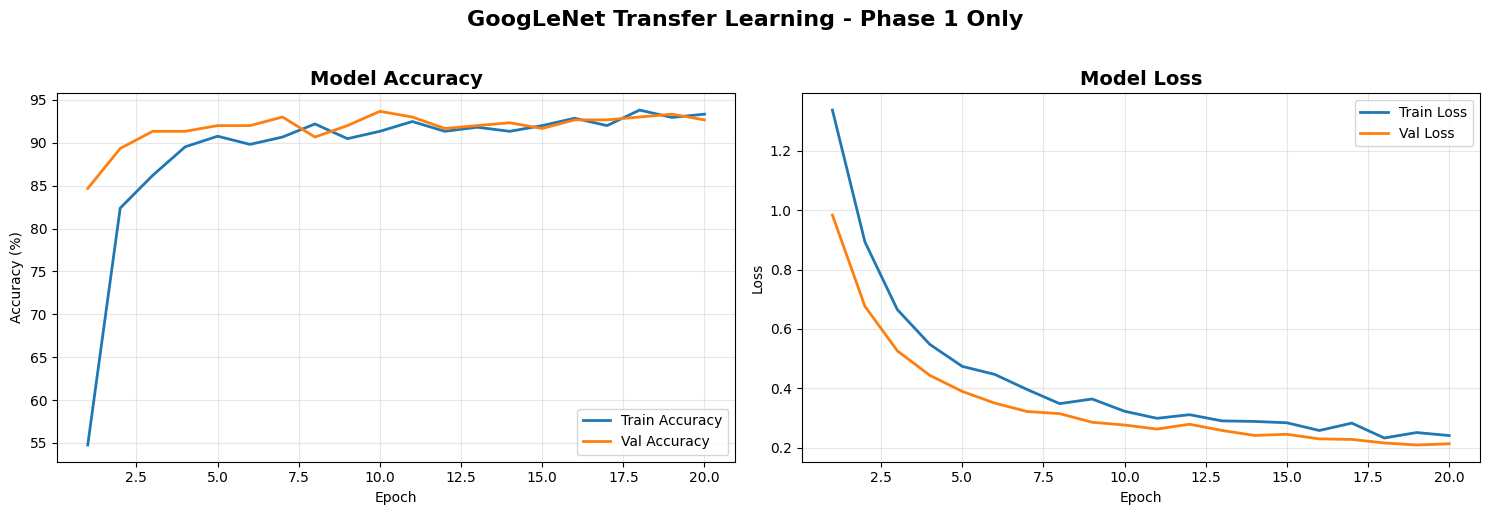

In [19]:
# =============================================
# 8. VISUALIZE RESULTS
# =============================================
print("\n" + "="*70)
print("VISUALIZING RESULTS")
print("="*70)

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Determine if we have phase 2 history
if history_phase2 is not None:
    epochs1 = len(history_phase1['train_acc']) - len(history_phase2['train_acc'])
    total_epochs = len(history_phase1['train_acc'])

    # Accuracy plot
    axes[0].plot(range(1, total_epochs + 1), history_phase1['train_acc'],
                 label='Train Accuracy', linewidth=2)
    axes[0].plot(range(1, total_epochs + 1), history_phase1['val_acc'],
                 label='Val Accuracy', linewidth=2)
    axes[0].axvline(x=epochs1, color='red', linestyle='--',
                    label='Fine-tuning starts', linewidth=2)
    axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy (%)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Loss plot
    axes[1].plot(range(1, total_epochs + 1), history_phase1['train_loss'],
                 label='Train Loss', linewidth=2)
    axes[1].plot(range(1, total_epochs + 1), history_phase1['val_loss'],
                 label='Val Loss', linewidth=2)
    axes[1].axvline(x=epochs1, color='red', linestyle='--',
                    label='Fine-tuning starts', linewidth=2)
    axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    title_suffix = ' - Two Phase Training'
else:
    # Only phase 1
    epochs1 = len(history_phase1['train_acc'])

    # Accuracy plot
    axes[0].plot(range(1, epochs1 + 1), history_phase1['train_acc'],
                 label='Train Accuracy', linewidth=2)
    axes[0].plot(range(1, epochs1 + 1), history_phase1['val_acc'],
                 label='Val Accuracy', linewidth=2)
    axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy (%)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Loss plot
    axes[1].plot(range(1, epochs1 + 1), history_phase1['train_loss'],
                 label='Train Loss', linewidth=2)
    axes[1].plot(range(1, epochs1 + 1), history_phase1['val_loss'],
                 label='Val Loss', linewidth=2)
    axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    title_suffix = ' - Phase 1 Only'

plt.suptitle(f'GoogLeNet Transfer Learning{title_suffix}',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(model_save_path, 'training_history.png'),
            dpi=300, bbox_inches='tight')
plt.show()

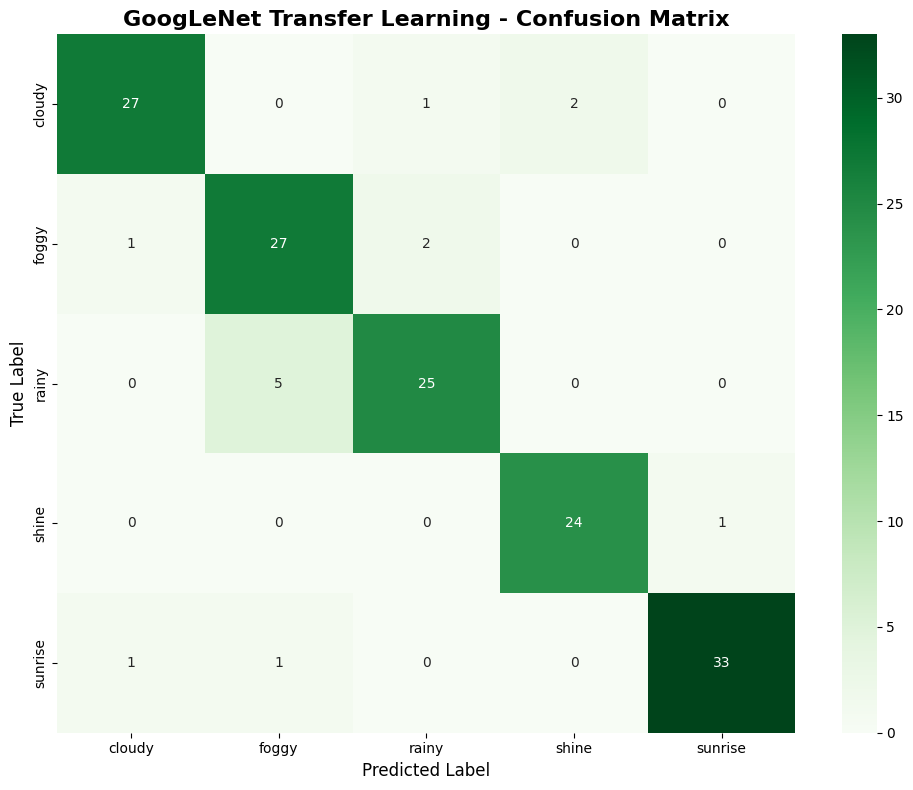


CLASSIFICATION REPORT
              precision    recall  f1-score   support

      cloudy     0.9310    0.9000    0.9153        30
       foggy     0.8182    0.9000    0.8571        30
       rainy     0.8929    0.8333    0.8621        30
       shine     0.9231    0.9600    0.9412        25
     sunrise     0.9706    0.9429    0.9565        35

    accuracy                         0.9067       150
   macro avg     0.9071    0.9072    0.9064       150
weighted avg     0.9087    0.9067    0.9069       150



In [20]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('GoogLeNet Transfer Learning - Confusion Matrix',
          fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(model_save_path, 'confusion_matrix.png'),
            dpi=300, bbox_inches='tight')
plt.show()

# Classification Report
print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))

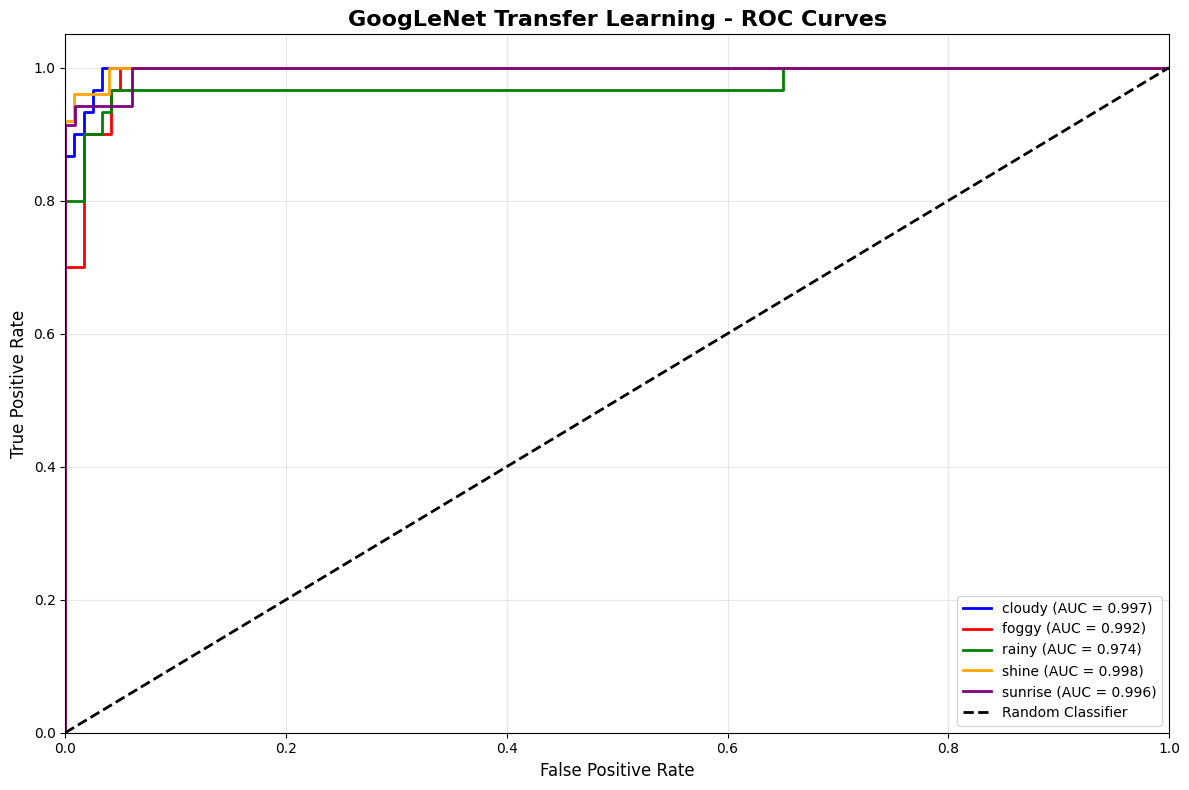


AUC Scores per Class:
  cloudy: 0.9972
  foggy: 0.9922
  rainy: 0.9742
  shine: 0.9981
  sunrise: 0.9963

Mean AUC: 0.9916


In [21]:
# ROC Curves
y_true_bin = label_binarize(y_true, classes=range(NUM_CLASSES))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple']

for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{CLASS_NAMES[i]} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('GoogLeNet Transfer Learning - ROC Curves',
          fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(model_save_path, 'roc_curves.png'),
            dpi=300, bbox_inches='tight')
plt.show()

print("\nAUC Scores per Class:")
for i in range(NUM_CLASSES):
    print(f"  {CLASS_NAMES[i]}: {roc_auc[i]:.4f}")
print(f"\nMean AUC: {np.mean(list(roc_auc.values())):.4f}")

In [22]:
# Save the complete model
torch.save({
    'model_state_dict': final_model.state_dict(),
    'num_classes': NUM_CLASSES,
    'class_names': CLASS_NAMES,
    'test_accuracy': test_accuracy,
    'test_loss': test_loss,
    'history': history_phase1,
    'model_architecture': 'googlenet',
    'weights_source': 'models.GoogLeNet_Weights.DEFAULT'
}, os.path.join(model_save_path, 'googlenet_final.pth'))

print(f"✓ Final model saved to: {os.path.join(model_save_path, 'googlenet_final.pth')}")

# Save predictions and metrics
results = {
    'y_true': y_true,
    'y_pred': y_pred,
    'y_probs': y_probs,
    'test_accuracy': test_accuracy,
    'test_loss': test_loss,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'auc_scores': {CLASS_NAMES[i]: float(roc_auc[i]) for i in range(NUM_CLASSES)},
    'mean_auc': float(np.mean(list(roc_auc.values()))),
    'training_time_minutes': total_training_time / 60,
    'model_name': 'GoogLeNet (Inception V1)',
    'weights_loading_code': "models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT, aux_logits=False)",
    'transfer_learning': True,
    'frozen_layers': True,
    'trainable_layers': 'fc layer only (initially)',
    'confusion_matrix': cm.tolist(),
    'class_names': CLASS_NAMES
}

np.save(os.path.join(model_save_path, 'inception_v1_results.npy'), results)

# Save training history
np.save(os.path.join(model_save_path, 'training_history.npy'), history_phase1)


✓ Final model saved to: /content/drive/MyDrive/models/inception_v1/googlenet_final.pth
